In [12]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("TestPySpark").getOrCreate()

# Check version
print("Spark version:", spark.version)


Spark version: 3.5.0


In [13]:
# Demo

spark = SparkSession.builder \
    .appName("FirstDemo") \
    .getOrCreate()

data = [("Virat", 82), ("Rohit", 65), ("Dhoni", 45)]
df = spark.createDataFrame(data, ["Player", "Runs"])

df.show()


+------+----+
|Player|Runs|
+------+----+
| Virat|  82|
| Rohit|  65|
| Dhoni|  45|
+------+----+



In [14]:
df_filtered = df.filter(df.Runs > 50)   # Transformation
df_filtered.show()                       # Action


+------+----+
|Player|Runs|
+------+----+
| Virat|  82|
| Rohit|  65|
+------+----+



In [3]:
# SQL in PySpark
df.createOrReplaceTempView("players")
spark.sql("SELECT * FROM players WHERE Runs > 50").show()


+------+----+
|Player|Runs|
+------+----+
| Virat|  82|
| Rohit|  65|
+------+----+



In [15]:
# RDD Example

from pyspark.sql import SparkSession

# 1. Initialize SparkSession and SparkContext
spark = SparkSession.builder \
    .appName("RDD_Partitions_Elements_Demo") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

# 2. Create an RDD with explicit partitions for clarity (e.g., 3 partitions)
data = list(range(1, 11))  # [1, 2, ..., 10]
print("\nInitial Data:", data)
rdd = sc.parallelize(data, numSlices=3)  # Forces 3 partitions
print("Number of partitions:", rdd.getNumPartitions())

# 3. Glom to get elements per partition, then collect
partition_elements = rdd.glom().collect()
print("Elements in each partition:")
for i, partition in enumerate(partition_elements):
    print(f"  Partition {i}: {partition}")

# 4. After a transformation (e.g., filter), partitions remain the same unless repartitioned
even_rdd = rdd.filter(lambda x: x % 2 == 0)
even_partitions = even_rdd.glom().collect()
print("\nElements in each partition after filter (evens only):")
for i, partition in enumerate(even_partitions):
    print(f"  Partition {i}: {partition}")

# 5. Partition sizes (number of elements per partition)
partition_sizes = rdd.glom().map(len).collect()
print("\nNumber of elements per partition:", partition_sizes)

# 5. Stop SparkSession
spark.stop()


Initial Data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Number of partitions: 3
Elements in each partition:
  Partition 0: [1, 2, 3]
  Partition 1: [4, 5, 6]
  Partition 2: [7, 8, 9, 10]

Elements in each partition after filter (evens only):
  Partition 0: [2]
  Partition 1: [4, 6]
  Partition 2: [8, 10]

Number of elements per partition: [3, 3, 4]


In [5]:
# DAG Demo

spark = SparkSession.builder.appName("DAGDemo").getOrCreate()
# Create another simple DataFrame
numbers = spark.range(0, 5)

# Transformations (still lazy)
doubled = numbers.withColumn("double", numbers["id"] * 2)
filtered = doubled.filter(doubled["double"] > 5)

# View the DAG plan Spark will execute
filtered.explain()

== Physical Plan ==
*(1) Project [id#33L, (id#33L * 2) AS double#35L]
+- *(1) Filter ((id#33L * 2) > 5)
   +- *(1) Range (0, 5, step=1, splits=12)




In [6]:
# Action that runs the DAG
filtered.show()

+---+------+
| id|double|
+---+------+
|  3|     6|
|  4|     8|
+---+------+



In [7]:
# LazyDemo

from pyspark import AccumulatorParam

spark = SparkSession.builder.appName("LazyDemo").getOrCreate()

#Accumulator increments only when tasks actually run
acc = spark.sparkContext.accumulator(0)
rdd = spark.sparkContext.parallelize(range(1, 11), numSlices=2)

def touch(x):
    acc.add(1)    # This runs on executors (only during actions)
    return x * x

squared = rdd.map(touch)   # transformation: still lazy

print("Before action, accumulator =", acc.value)

# ACTION triggers the map() execution and accumulator updates
_ = squared.collect()

print("After action, accumulator =", acc.value)

Before action, accumulator = 0
After action, accumulator = 10


In [8]:
# Cache Demo

import time
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CacheDemo").getOrCreate()

rdd = spark.sparkContext.parallelize(range(1, 10_000_000))

# Expensive operation: square and sum
def timed_run(label, rdd_action):
    start = time.time()
    result = rdd_action()
    duration = time.time() - start
    print(f"{label}: {duration:.3f} sec")
    return result, duration

# No cache
timed_run("No cache", lambda: rdd.map(lambda x: x * x).sum())

# Cache it and re-run
squared = rdd.map(lambda x: x * x).cache()
squared.count()  # trigger caching

timed_run("Cached run", lambda: squared.sum())

No cache: 0.953 sec
Cached run: 0.546 sec


(333333283333335000000, 0.5464568138122559)

In [9]:
# Normal and Broadcast join

from pyspark.sql import SparkSession
from pyspark.sql.functions import broadcast
import time

spark = SparkSession.builder.appName("NormalBroadcastJoin").getOrCreate()

# Large dataset (simulated)
df_large = spark.range(0, 5_000_000).withColumnRenamed("id", "num")

# Small lookup table
df_small = spark.createDataFrame([(i, i * 10) for i in range(5_000)], ["num", "value"])

#Normal join (no broadcast)
start = time.time()
df_join = df_large.join(df_small, "num", "inner").count()
print(f"Normal join: {time.time() - start:.3f} sec")

# Broadcast join
start = time.time()
df_broadcast = df_large.join(broadcast(df_small), "num", "inner").count()
print(f"Broadcast join: {time.time() - start:.3f} sec")

Normal join: 2.628 sec
Broadcast join: 0.667 sec


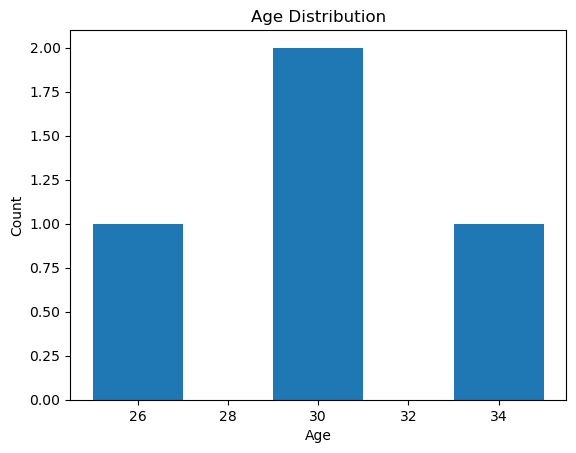

In [11]:
# Visualizations

import matplotlib.pyplot as plt

# Example data
data = [("Alice", 25), ("Bob", 30), ("Charlie", 35), ("David", 30)]
columns = ["Name", "Age"]

df = spark.createDataFrame(data, columns)

# Convert to Pandas
pdf = df.toPandas()

# Plot histogram of ages
plt.hist(pdf["Age"], bins=5)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()
